In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
import sklearn.dummy
import sklearn.metrics
import sklearn.neural_network
import sklearn.ensemble

Fetch the data frames from the files

In [2]:
# read both the matches and the frames
training_df = pd.read_csv('../data/processed/diff_train.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
test_df = pd.read_csv('../data/processed/diff_test.csv').drop(labels=['tier','Unnamed: 0'],axis=1)
# Reinterpret all values as int32s
training_df = training_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})
test_df = test_df.astype({
    'winner': 'int32',
    'first_kill': 'int32',
    'first_tower': 'int32',
    'first_inhibitor': 'int32',
    'first_baron': 'int32',
    'first_dragon': 'int32',
    'first_rift_herald': 'int32',
})



Helper functions to format the data prior to training

In [3]:

def plot_data(X, y):
    """Plots the data from Exercise 1"""
    plt.scatter(*X[y==-1].T, marker="x", c="r")
    plt.scatter(*X[y==1].T, marker="x", c="b")
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.gca().set_aspect('equal')  

def plot_decision_function(model):
    """
    Plots the decision function of a model as a red-blue heatmap.
    The region evaluated, along with x and y axis limits, are determined by 'extent'.
    """
    extent = (0,1,0,1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 200), np.linspace(x2min, x2max, 200))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.decision_function(X).reshape(x1.shape)
    plt.imshow(-y, extent=extent, origin='lower', vmin=-1, vmax=1, cmap='bwr', alpha=0.5, interpolation='nearest')
    if y.min() < 0 and y.max() > 0:
        plt.contour(x1, x2, y, levels=[0], colors=['k'])  # Decision boundary
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    
def plot_rf_prediction(model):
    """
    Plots the model's predictions over all points in range 2D [-3, 3].
    Assumes at most 3 classes.
    """
    extent = (0, 1, 0, 1)
    x1min, x1max ,x2min, x2max = extent
    x1, x2 = np.meshgrid(np.linspace(x1min, x1max, 100), np.linspace(x2min, x2max, 100))
    X = np.column_stack([x1.ravel(), x2.ravel()])
    y = model.predict(X).reshape(x1.shape)
    cmap = matplotlib.colors.ListedColormap(['r', 'b', 'g'])
    plt.imshow(y, extent=extent, origin='lower', alpha=0.4, vmin=0, vmax=2, cmap=cmap, interpolation='nearest')
    plt.xlim([x1min, x1max])
    plt.ylim([x2min, x2max])
    plt.gca().set_aspect('equal')

def scale_data(X_trn, X_tst):
    # Scale the data with MinMax to avoid negative values
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(X_trn)
    X_trn = scaler.transform(X_trn)
    X_tst = scaler.transform(X_tst)

    return X_trn, X_tst

def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores = [0 for _ in range(len(estimators))]
    for x in range(len(estimators)):
        scores[x] = sklearn.metrics.accuracy_score(y, estimators[x].predict(X))
        print(sklearn.metrics.precision_recall_fscore_support(y, estimators[x].predict(X), average='binary'))
    return scores

def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need
    plt.figure()
    X = np.arange(0, len(param_vals))
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    index = np.argmin(trn_scores - tst_scores)
    print(tst_scores[index])
    plt.title(estimators[0].__class__.__name__ + " score vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.ylim(0.0, 1.05)
    plt.scatter(X[index], tst_scores[index], marker='x', color='black', s=200)
    plt.plot(X, trn_scores, marker='o', color='green', markerfacecolor='green', label="train")
    plt.plot(X, tst_scores, marker='o', color='red', markerfacecolor='red', label="test")
    plt.text(0, 0.4,
             "Optimal Test Accuracy = %.2f%% with %s = %d " % (tst_scores[index] * 100, param_name, param_vals[index]))
    plt.legend()
    plt.xticks(X, param_vals)
    

def train_estimators(X, y, estimator, param_grid, cv=3):
    gscv = sklearn.model_selection.GridSearchCV(estimator, param_grid=param_grid, verbose=1, cv=3)
    gscv.fit(X, y)
    print(gscv.cv_results_)
    print(gscv.best_params_)
    return gscv


Feature selection: Select an X and y we want to train on

In [4]:
X_trn = training_df[['kill_advantage','gold_advantage']].values
y_trn = training_df[['winner']].values.T[0]
X_tst = test_df[['kill_advantage','gold_advantage']].values
y_tst = test_df[['winner']].values.T[0]
X_trn, X_tst = scale_data(X_trn, X_tst)


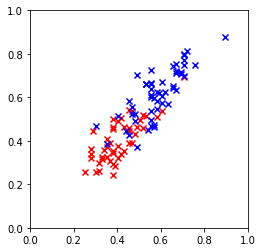

In [5]:
plot_data(X_tst[:100], y_tst[:100])

## Dummy Classifier

In [6]:

## Here we train a dummy classifier to compare performance
def train_dummy_classifier(X, y):
    dummy_clf = sklearn.dummy.DummyClassifier(strategy='uniform', random_state=0)
    # Scale the data with MinMax to avoid negative values
    dummy_clf.fit(X, y)
    return dummy_clf


## kNN 

In [7]:
def train_kNN_estimators(X, y):
    param_grid = {
        'n_neighbors': [1, 5, 10, 15, 20]
    }
    clf = sklearn.neighbors.KNeighborsClassifier()
    knn_estimators = train_estimators(X, y, estimator=clf, param_grid=param_grid)
    
    return knn_estimators.best_estimator_
    plot_estimator_scores(knn_estimators, param_name='n_neighbors', param_vals=param_vals)


## Random Forests

In [8]:
def train_random_forests(X, y):
    estimator = np.arange(1, 5) * 50
    depths = np.arange(1, 5) * 5
    param_grid = {
        'n_estimators': estimator, 
        'max_depth': depths
    }
    clf = sklearn.ensemble.RandomForestClassifier(random_state=0)
    gscv = train_estimators(X, y, estimator=clf, param_grid=param_grid)
    return gscv.best_estimator_

## AdaBoost

In [ ]:
def train_adaboost(X, y):
    pass

## Logistic

In [ ]:
def train_logistic(X, y):
    pass

## SVM

In [ ]:
def train_svm(X, y):
    pass

## Neural Network

In [9]:
## This is the neural network trained in Lab 8

def train_neural_network(X, y):
    net = sklearn.neural_network.MLPClassifier(        
        learning_rate_init=0.01,
        momentum=0.9,
        solver='sgd',
        random_state=0,
        verbose=True
    )
    param_grid = [
        {
            'activation' : ['logistic', 'tanh'],
            'hidden_layer_sizes': [
             (), (1,),(2,),(3,),
            ]
        }
    ]
    gscv = train_estimators(X, y, estimator=net, param_grid=param_grid)
    return gscv.best_estimator_
# train_neural_network(X_trn,y_trn)

## Evaluation

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Iteration 1, loss = 0.67776433
Iteration 2, loss = 0.66063632
Iteration 3, loss = 0.64652522
Iteration 4, loss = 0.63331269
Iteration 5, loss = 0.62099495
Iteration 6, loss = 0.60948657
Iteration 7, loss = 0.59877332
Iteration 8, loss = 0.58876504
Iteration 9, loss = 0.57935828
Iteration 10, loss = 0.57054885
Iteration 11, loss = 0.56233498
Iteration 12, loss = 0.55456744
Iteration 13, loss = 0.54725492
Iteration 14, loss = 0.54044482
Iteration 15, loss = 0.53397881
Iteration 16, loss = 0.52794604
Iteration 17, loss = 0.52221220
Iteration 18, loss = 0.51681651
Iteration 19, loss = 0.51166502
Iteration 20, loss = 0.50683707
Iteration 21, loss = 0.50223881
Iteration 22, loss = 0.49788550
Iteration 23, loss = 0.49377467
Iteration 24, loss = 0.48990196
Iteration 25, loss = 0.48609963
Iteration 26, loss = 0.48251458
Iteration 27, loss = 0.47914464
Iteration 28, loss = 0.47590354
Iteration 29, loss = 0.47280768
Iteration 30, loss = 

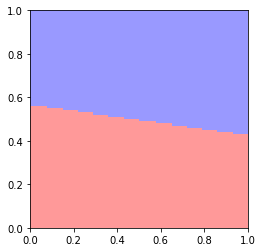

In [10]:

dm_clf = train_dummy_classifier(X_trn, y_trn)
logistic_clf = train_logistic(X_trn, y_trn)
boost_clf = train_adaboost(X_trn, y_trn)
svm_clf = train_svm(X_trn, y_trn)
nn_clf = train_neural_network(X_trn, y_trn)
knn_clf = train_kNN_estimators(X_trn, y_trn)
rf_clf = train_random_forests(X_trn, y_trn)

# y_pred = dm_clf.predict(X_tst)
# stats = sklearn.metrics.precision_recall_fscore_support(y_tst, y_pred, average='binary')
# sklearn.metrics.accuracy_score(y_tst, y_pred)


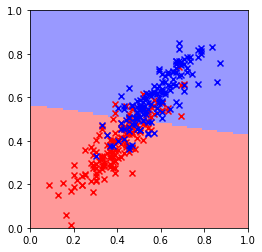

In [12]:
plt.figure()
plot_data(X_trn[:300], y_trn[:300])
plot_rf_prediction(nn_clf)